Progetto: Stimare il valore di appartamenti in California
===========================================

Il modello risultante sarà utilizzato per alimentare un successivo sistema che da delle indicazioni di investimento immobiliare.

Seleziona misura di performance => Errore quadratico medio, Root Mean Square Error
Overview dei dati

Esempio
https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from pandas.plotting import scatter_matrix


## Dizionario dei dati
* longitude, latitude => posizione del distretto
* housing_median:age => età media degli immobli
* total_rooms, total_bedrooms => numero totale di stanze nel distretto
* population => popolazione del distretto
* households => numero di immobili
* median_income => reddito medio / 10000 (es: 0,5 = 5000 USD, 12.5 = 12500 USD), limitato all'intervallo 0.5 - 15.0 circa
* median_house_value => valore medio delle case nel territorio
* ocean_proximity => se vicino al mare o no

In [2]:
# Load the california-housing-prices.csv into a Pandas dataset.
def load_housing_data():
    csv_path = os.path.join("datasets", "california-housing-prices.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()

## Esplorare i dati

In [3]:
# avere una prima panormaica dei dati
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [4]:
housing.info()
# notare che circa 200 righe non hanno la feature "total_bedrooms"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
# quali sono i valori di ocean_proximity ?
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
# overview delle feature numeriche
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022AF7D66908>,
      dtype=object)

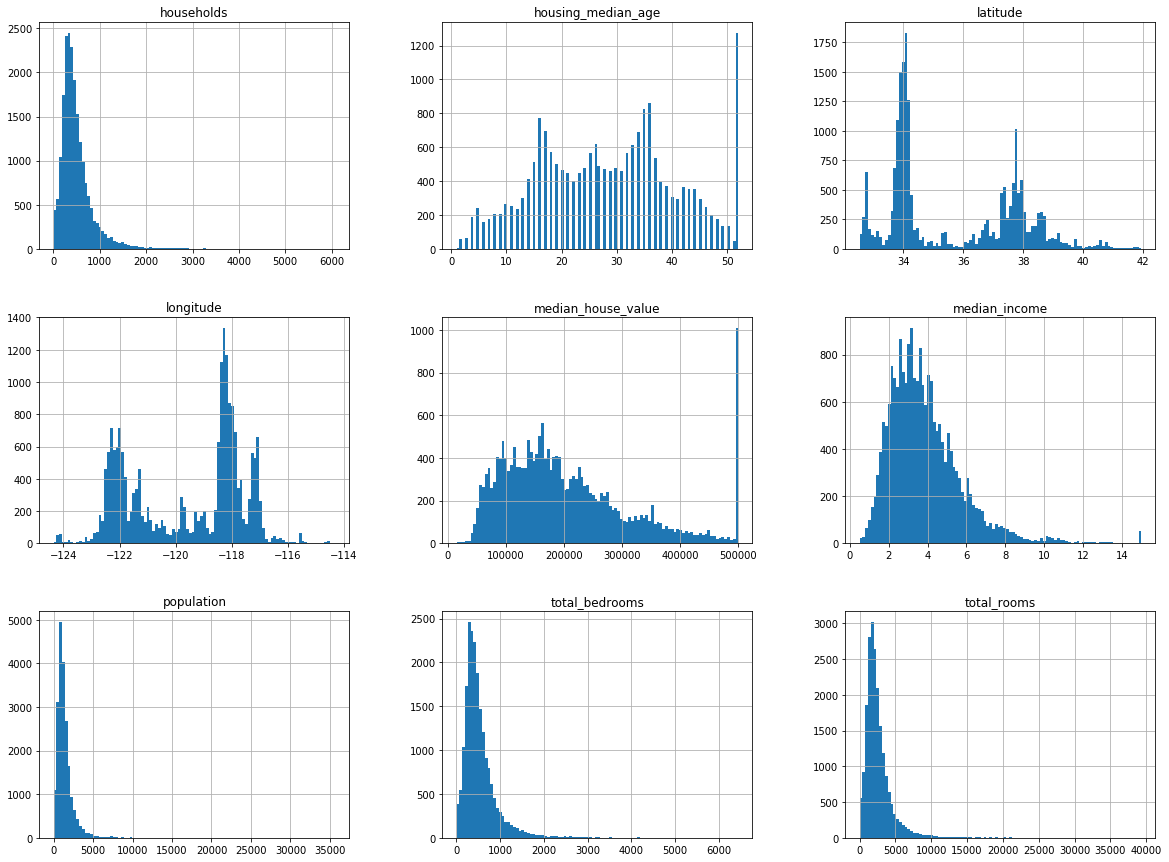

In [7]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.hist.html
housing.hist(bins=100, figsize=(20,15))

In [8]:
# suddivisione randomica dei dati in set di training e set di test
def split_train_test(data, test_ratio):
    
    # crea un array con i numeri 1, 2... fino alla lunghezza dei dati, in cui i numeri appaiono in ordine casuale
    shuffled_indices = np.random.permutation(len(data))
    
    # calcola la dimensione dei dati di test come percentuale di tutti i dati
    test_set_size = int(len(data) * test_ratio)
    
    # estrae i numeri disordinati presenti nelle posizioni [0 - test_set_size)
    test_indices = shuffled_indices[:test_set_size]
    
    # estrae i numeri disordinati presenti nelle posizioni [test_set_size, fine]
    train_indices = shuffled_indices[test_set_size:]
    
    # restituisce due data frame
    # 1. con i dati i cui indici sono negli indici di training
    # 2. con i dati i cui indici sono negli indici di test
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(housing, 0.2)

In [9]:
len(train_set)

16512

In [10]:
len(test_set)

4128

<img src="https://www.freeworldmaps.net/united-states/california/california-counties-map.jpg" width="500"/>



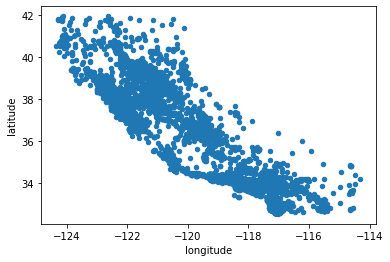

In [11]:
train_set.plot(kind="scatter", x="longitude", y="latitude")

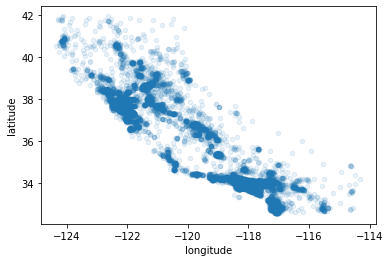

In [12]:
train_set.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

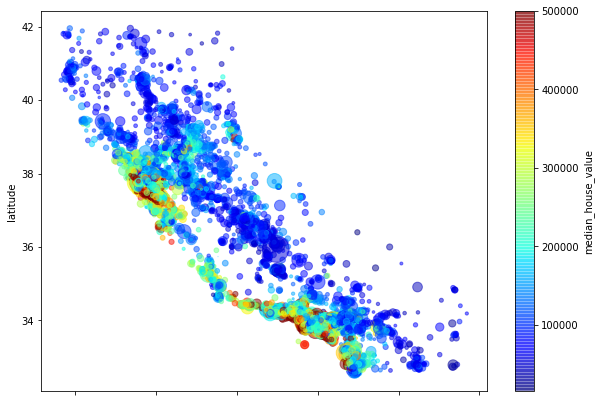

In [13]:
train_set.plot(kind="scatter", x="longitude", y="latitude", alpha=0.5, s=housing["population"]/50, 
               c="median_house_value", cmap=plt.get_cmap("jet"), figsize=(10,7), colorbar=True)


In [14]:
# Correlation
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022AF966BDC8>,
      dtype=object)

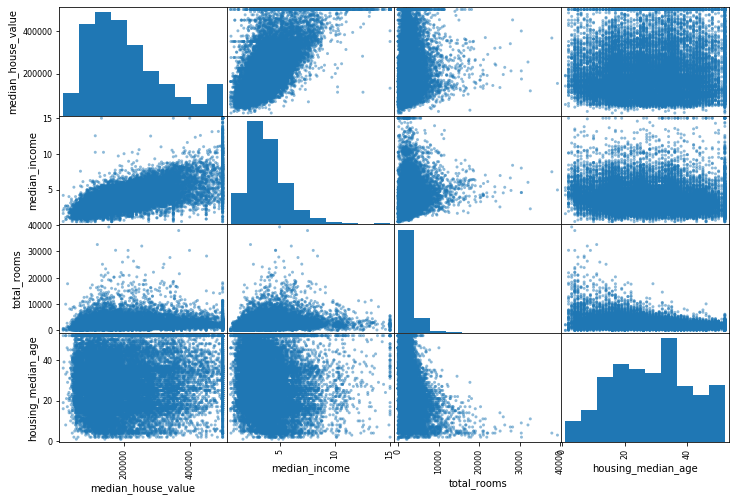

In [15]:


attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

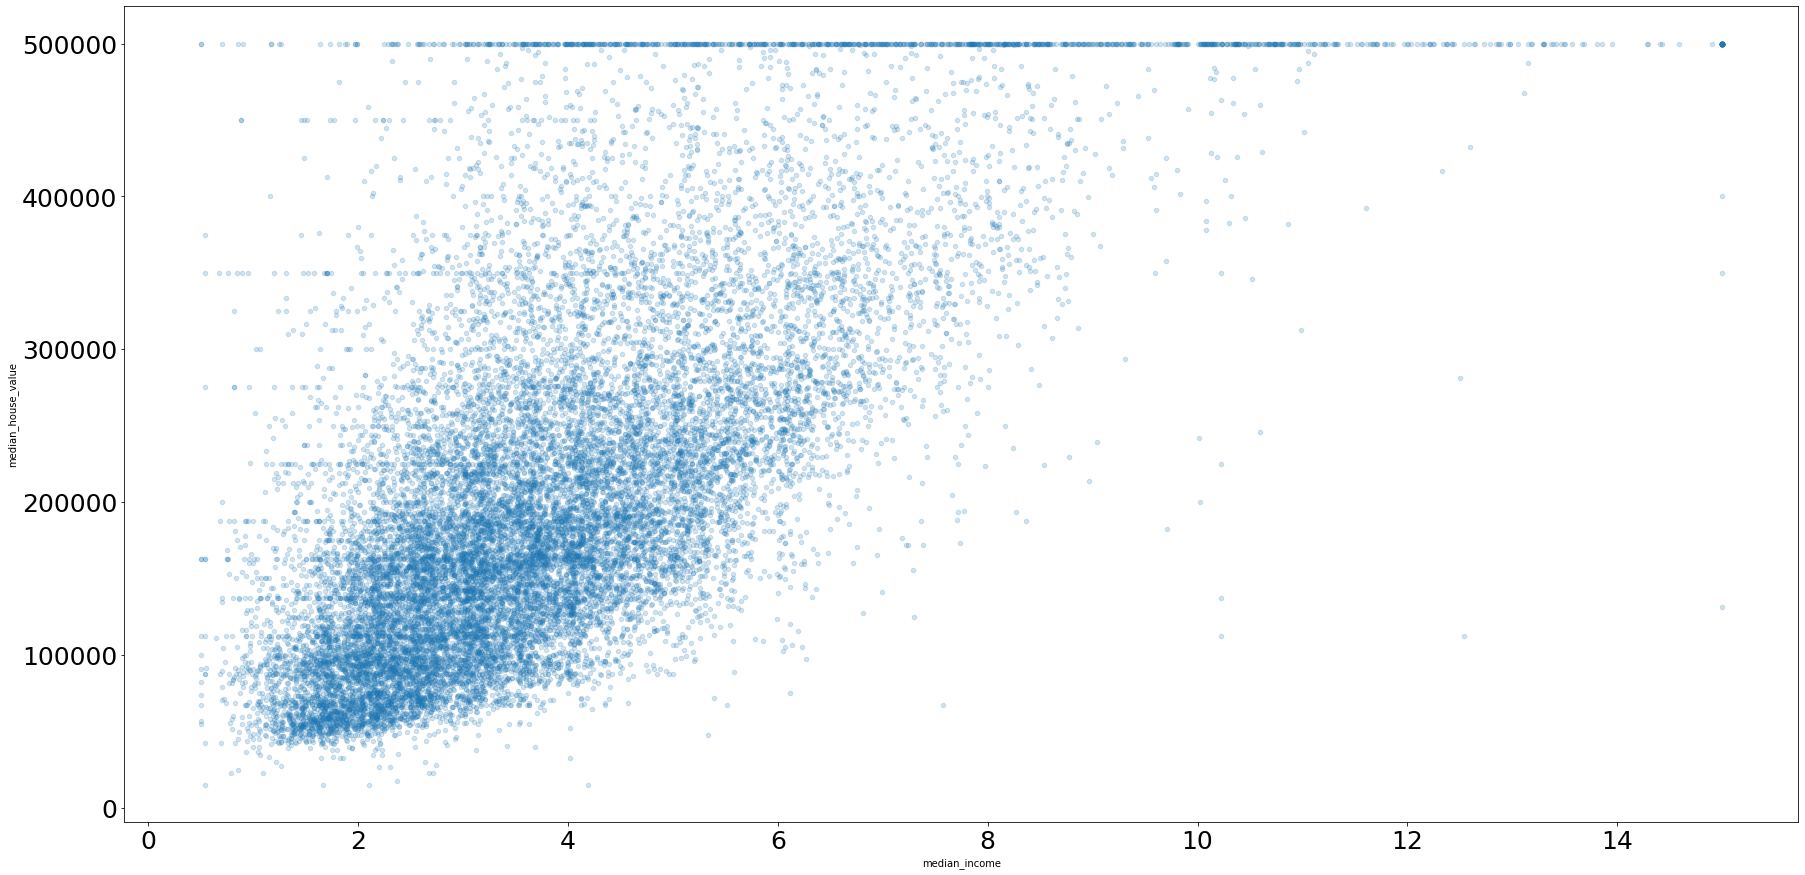

In [16]:
# Zoom su "median_income / median_house_value" e...
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.2, figsize=(30,15), fontsize=25)

In [17]:
# Proviamo con parametri calcolati che potrebbero essere più significativi.
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]
housing.corr()["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022AFB3D12C8>,
      dtype=object)

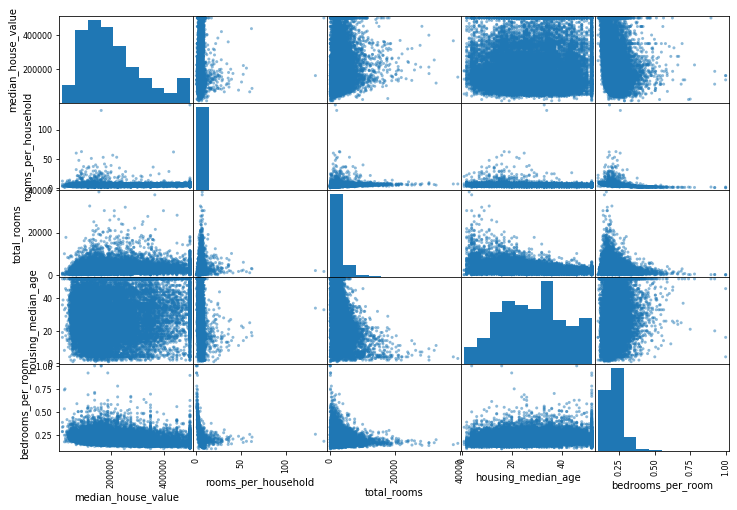

In [18]:
attributes = ["median_house_value", "rooms_per_household", "total_rooms",
              "housing_median_age", "bedrooms_per_room"]
scatter_matrix(housing[attributes], figsize=(12, 8))

# Preparare i dati per il Machine Learning

In [26]:
# check total_bedrooms count. It is not the same that other fields. So some data is missing there
train_set.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,16512.000000,16512.000000,16512.000000,16512.000000,16360.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-119.578986,35.635218,28.676962,2636.640019,536.572983,1426.847989,499.242248,3.882293,207364.254784
std,2.004907,2.135188,12.535425,2199.395905,422.710922,1148.952994,384.759395,1.914072,115306.097848
min,-124.350000,32.550000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.810000,33.930000,18.000000,1445.000000,295.000000,788.000000,279.000000,2.562500,120700.000000
50%,-118.510000,34.260000,29.000000,2126.000000,433.000000,1167.000000,409.000000,3.544450,180500.000000
75%,-118.010000,37.710000,37.000000,3147.250000,644.000000,1726.000000,605.000000,4.759275,265300.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [33]:
print( housing["total_bedrooms"].median() ) # median, split the population in half, usually a better suited value.
print( housing["total_bedrooms"].mean() ) # mean / average

435.0
537.8705525375618


In [40]:
value=housing["total_bedrooms"].median()
train_set["total_bedrooms"].fillna(
    value,
    inplace=True
)



In [42]:
train_set.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-119.578986,35.635218,28.676962,2636.640019,535.637960,1426.847989,499.242248,3.882293,207364.254784
std,2.004907,2.135188,12.535425,2199.395905,420.872499,1148.952994,384.759395,1.914072,115306.097848
min,-124.350000,32.550000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.810000,33.930000,18.000000,1445.000000,296.750000,788.000000,279.000000,2.562500,120700.000000
50%,-118.510000,34.260000,29.000000,2126.000000,435.000000,1167.000000,409.000000,3.544450,180500.000000
75%,-118.010000,37.710000,37.000000,3147.250000,641.000000,1726.000000,605.000000,4.759275,265300.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [49]:
# Let's do it with scikit
#from sklearn.impute import SimpleImputer
train_set_only_numbers = train_set.drop(columns="ocean_proximity")
imputer = SimpleImputer(strategy="median")
imputer.fit( train_set_only_numbers )
imputer.statistics_

array([-1.18510e+02,  3.42600e+01,  2.90000e+01,  2.12600e+03,
        4.35000e+02,  1.16700e+03,  4.09000e+02,  3.54445e+00,
        1.80500e+05])

In [53]:
train_set_only_numbers.median().values

array([-1.18510e+02,  3.42600e+01,  2.90000e+01,  2.12600e+03,
        4.35000e+02,  1.16700e+03,  4.09000e+02,  3.54445e+00,
        1.80500e+05])

In [59]:
X = imputer.transform(train_set_only_numbers)


### Modello

In [68]:
print(train_set)
housing_features = train_set.drop(columns=["median_house_value", "ocean_proximity"])
housing_labels = train_set["median_house_value"].copy()
print(housing_features)
print(housing_labels)

       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
9515     -123.20     39.16                14.0       1908.0           484.0   
4180     -118.22     34.09                45.0       1072.0           275.0   
11901    -117.36     33.92                 7.0       9376.0          1181.0   
5062     -118.28     33.99                37.0       1971.0           513.0   
14546    -117.26     32.95                15.0       1882.0           233.0   
...          ...       ...                 ...          ...             ...   
17091    -122.23     37.48                33.0       3108.0           805.0   
14117    -117.11     32.73                34.0       1096.0           221.0   
12364    -116.46     33.82                 6.0       4863.0           920.0   
11474    -117.99     33.71                17.0       1600.0           458.0   
3653     -118.43     34.22                34.0       2300.0           429.0   

       population  households  median_income  media

In [70]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")), # All but the last estimator must be transformers (i.e., they must have a fit_transform() method)
        ('std_scaler', StandardScaler()),
    ])

housing_features_normalized = num_pipeline.fit_transform(housing_features)

print(housing_features_normalized)

[[-1.80613099  1.65085633 -1.1708743  ... -0.20179678 -0.08380101
  -1.09162904]
 [ 0.67785038 -0.72371369  1.30219218 ... -0.37500319 -0.66600065
  -0.55532159]
 [ 1.10681101 -0.80333438 -1.72930867 ...  1.86536518  1.57962655
   2.42960949]
 ...
 [ 1.55572331 -0.85017008 -1.809085   ...  1.37795015  0.8544761
   0.03579215]
 [ 0.79257241 -0.90168935 -0.93154529 ...  0.32739668 -0.1747697
  -0.57251059]
 [ 0.57310417 -0.66282728  0.42465246 ...  0.01753999 -0.11499027
   0.20026326]]


In [71]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_features_normalized, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [101]:
houses = housing_features.iloc[0:3]
print(houses)
print(lin_reg.predict( num_pipeline.transform(houses) )) # pay attention here, data is transformed!



       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
9515     -123.20     39.16                14.0       1908.0           484.0   
4180     -118.22     34.09                45.0       1072.0           275.0   
11901    -117.36     33.92                 7.0       9376.0          1181.0   

       population  households  median_income  
9515       1195.0       467.0         1.7929  
4180        996.0       243.0         2.8194  
11901      3570.0      1107.0         8.5326  
[119815.87836015 177946.86078211 317691.69747818]


In [111]:
from sklearn.metrics import mean_squared_error

print(housing_labels)
print( type(housing_labels) )
#print(num_pipeline.transform(housing_labels))
# prediction of values compared to dataset labels
#housing_predictions = lin_reg.predict( num_pipeline.transform(housing_labels) )
#lin_rmse = np.sqrt( mean_squared_error(housing_labels, housing_predictions) )


9515      82300.0
4180     165000.0
11901    315200.0
5062     103000.0
14546    500001.0
           ...   
17091    267700.0
14117    126700.0
12364    104200.0
11474    216700.0
3653     233700.0
Name: median_house_value, Length: 16512, dtype: float64
<class 'pandas.core.series.Series'>
